# **CheXpert Chest X-Ray Dataset**

- [dataset](https://stanfordmlgroup.github.io/competitions/chexpert/)
- [Read the Paper (Irvin & Rajpurkar et al.)](https://arxiv.org/abs/1901.07031)


## What is CheXpert?

CheXpert is a large dataset of chest X-rays and competition for automated chest x-ray interpretation, which features uncertainty labels and radiologist-labeled reference standard evaluation sets.


## Why CheXpert?

Chest radiography is the most common imaging examination globally, critical for screening, diagnosis, and management of many life threatening diseases. Automated chest radiograph interpretation at the level of practicing radiologists could provide substantial benefit in many medical settings, from improved workflow prioritization and clinical decision support to large-scale screening and global population health initiatives. For progress in both development and validation of automated algorithms, we realized there was a need for a labeled dataset that (1) was large, (2) had strong reference standards, and (3) provided expert human performance metrics for comparison.

---

## In the CheXpert series:

- ### [**🩻 CheXpert X-Rays Dataset | Data Visuals 🫁**](https://www.kaggle.com/code/shreydan/chexpert-x-rays-dataset-data-visuals)

### In this notebook, we'll be training a multi-label image classifier on the CheXpert dataset for the following labels: 

| Term             | Description                                                               |
|-----------------|:--------------------------------------------------------------------------|
| Atelectasis      | Incomplete collapse of lung tissue                                        |
| Cardiomegaly     | Enlargement of the heart                                                  |
| Consolidation    | Filling of air spaces in the lung with fluid                              |
| Edema            | Excess fluid in the tissues                                               |
| Pleural Effusion | Abnormal collection of fluid in the space between the lung and chest wall |


# Imports

In [1]:
!pip install -Uq transformers accelerate datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedGroupKFold
from pathlib import Path
from collections import Counter
import datasets
from transformers import AutoModelForImageClassification, Trainer, TrainingArguments
from torchmetrics.functional.classification import (multilabel_auroc, 
                                                    multilabel_exact_match,
                                                    multilabel_specificity,
                                                    multilabel_hamming_distance
                                                   )
from types import SimpleNamespace
import wandb

tqdm.pandas()

2024-05-16 20:17:28.779969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 20:17:28.780078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 20:17:29.054134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Basic Data Preparation

- I'll be splitting the `train` dataset into train and validation.
- I'll be using the `validation` dataset for testing.

In [3]:
base_path = Path('/kaggle/input/chexpert')

In [4]:
train_df = pd.read_csv('/kaggle/input/chexpert/CheXpert-v1.0-small/train.csv')
test_df = pd.read_csv('/kaggle/input/chexpert/CheXpert-v1.0-small/valid.csv')

train_df['Path'] = train_df['Path'].progress_map(lambda p: base_path/Path(p))
test_df['Path'] = test_df['Path'].progress_map(lambda p: base_path/Path(p))

  0%|          | 0/223414 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

# Target Columns for Training Models

- we have all possible labels: `all_target_cols`
- labels which were specific to CheXpert competition: `target_cols`

## imputation:

- fill N/A values with 0
- keep uncertain (-1) values, I'll be masking these labels from the calculated loss, hence keeping
    - other methods to replace uncertain values: replace with 0s, replace with 1s, create a new class (2) corresponding to uncertainty prediction


In [5]:
get_patient_id = lambda p: int(p.parent.parent.stem.replace('patient',''))

train_df['PatientID'] = train_df['Path'].progress_map(get_patient_id)

  0%|          | 0/223414 [00:00<?, ?it/s]

In [6]:
all_target_cols = [
    'No Finding',
    'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices'
]
target_cols = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']


keep_cols = ['Path','PatientID'] + target_cols

In [7]:
train_df[keep_cols].head()

,Path,PatientID,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural Effusion
0,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,1,NaN,NaN,NaN,NaN,NaN
1,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,2,-1.0,-1.0,-1.0,-1.0,-1.0
2,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,2,NaN,NaN,-1.0,NaN,NaN
3,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,2,NaN,NaN,-1.0,NaN,NaN
4,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,3,NaN,NaN,NaN,1.0,NaN


In [8]:
train_df.fillna(value=0,inplace=True)
test_df.fillna(value=0,inplace=True)


train_df[all_target_cols] = train_df[all_target_cols].astype(int)
test_df[all_target_cols] = test_df[all_target_cols].astype(int)

In [9]:
train_df = train_df.drop(columns=[c for c in train_df.columns if c not in keep_cols])
test_df = test_df.drop(columns=[c for c in test_df.columns if c not in keep_cols])

train_df['Path'] = train_df['Path'].progress_map(lambda p:str(p))
test_df['Path'] = test_df['Path'].progress_map(lambda p:str(p))

  0%|          | 0/223414 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

# Train-Valid Split

- the stratification is done based on total no. of diseases present, it can also be uncertain.
- We apply `StratifiedGroupKFold` to split our data for stratified distribution of the classes along with patient-level splitting. The patients in train data won't be available in the validation data.

In [10]:
stratify_col = lambda x,cols: ''.join([f"{x[c]}" for c in cols])
stratify_col_sum = lambda x,cols: sum([abs(x[c]) for c in cols])

train_df['stratify'] = train_df.progress_apply(lambda x:stratify_col_sum(x, target_cols), axis=1)
sgkf = StratifiedGroupKFold(n_splits=8,shuffle=True)

for fold, (train_idx, val_idx) in tqdm(enumerate(sgkf.split(train_df,train_df['stratify'],train_df['PatientID'])),total=8):
    train_df.loc[val_idx,'fold'] = fold

train_df['fold'] = train_df['fold'].astype(int)
train_df.drop(columns=['stratify'],inplace=True)

train_df.reset_index(drop=True,inplace=True)

  0%|          | 0/223414 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [11]:
train_df.head()

,Path,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion,PatientID,fold
0,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,0,0,0,0,0,1,4
1,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,-1,-1,-1,-1,-1,2,2
2,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,0,0,-1,0,0,2,2
3,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,0,0,-1,0,0,2,2
4,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,0,1,0,0,0,3,4


In [12]:
def combine_label_cols(df, label_cols):
    combine = lambda x: ','.join([f"{x[c]}" for c in label_cols])
    df['labels'] = df.progress_apply(combine, axis=1)
    df = df.drop(columns=label_cols)
    return df.reset_index(drop=True)

def get_fold(df,fold=0):
    train = df[df['fold']!=fold].reset_index(drop=True)
    valid = df[df['fold']==fold].reset_index(drop=True)
    return train, valid

In [13]:
fold_0_train,fold_0_valid = get_fold(train_df, fold=0)
len(fold_0_train), len(fold_0_valid)

(195851, 27563)

# Label Distribution

In [14]:
ones = 0
zeros = 0
for col in target_cols:
    t = fold_0_train[col].value_counts().to_dict()
    v = fold_0_valid[col].value_counts().to_dict()
    te = test_df[col].value_counts().to_dict()
    print(col)
    for k in [0,1,-1]:
        print(f"{k}\ttrain: {t[k]} valid: {v[k]} test: {te.get(k,0)}")
    print()
    zeros += t[0]
    ones += t[1]
    
print('possible gamma_neg for the loss_fn:',zeros//ones)

Atelectasis
0	train: 136993 valid: 19306 test: 154
1	train: 29167 valid: 4209 test: 80
-1	train: 29691 valid: 4048 test: 0

Cardiomegaly
0	train: 165069 valid: 23258 test: 166
1	train: 23712 valid: 3288 test: 68
-1	train: 7070 valid: 1017 test: 0

Consolidation
0	train: 158396 valid: 22493 test: 201
1	train: 13033 valid: 1750 test: 33
-1	train: 24422 valid: 3320 test: 0

Edema
0	train: 138581 valid: 19603 test: 189
1	train: 45868 valid: 6378 test: 45
-1	train: 11402 valid: 1582 test: 0

Pleural Effusion
0	train: 110099 valid: 15500 test: 167
1	train: 75627 valid: 10560 test: 67
-1	train: 10125 valid: 1503 test: 0

possible gamma_neg for the loss_fn: 3


## We're combining the labels into a list so that it becomes easier to one-hot encode

In [15]:
target_cols = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
id2label = {i:l for i,l in enumerate(target_cols)}
label2id = {l:i for i,l in id2label.items()}


fold_0_train = combine_label_cols(fold_0_train, target_cols)
fold_0_valid = combine_label_cols(fold_0_valid, target_cols)
test_df_combined = combine_label_cols(test_df, target_cols)
train_df_combined = combine_label_cols(train_df, target_cols)

fold_0_train.head()

train_df_combined.to_csv('train_df.csv',index=False)
test_df_combined.to_csv('test_df.csv',index=False)

  0%|          | 0/195851 [00:00<?, ?it/s]

  0%|          | 0/27563 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/223414 [00:00<?, ?it/s]

# Creating a Dataset using Hugging Face Datasets

In [16]:
train_ds = datasets.Dataset.from_pandas(fold_0_train).cast_column('Path',datasets.Image())
valid_ds = datasets.Dataset.from_pandas(fold_0_valid).cast_column('Path',datasets.Image())
test_ds = datasets.Dataset.from_pandas(test_df_combined).cast_column('Path',datasets.Image())
label_ds = datasets.Dataset.from_pandas(train_df_combined).cast_column('Path',datasets.Image())
len(train_ds), len(valid_ds), len(test_ds), len(label_ds)

(195851, 27563, 234, 223414)

# Training and Validation Augmentations

In [17]:
img_size = 384
mean = (0.485,0.456,0.406)
std = (0.229,0.224,0.225)
train_tfms = A.Compose([
    A.Rotate(15),
    A.Resize(img_size,img_size),
    A.HorizontalFlip(),
    A.Normalize(mean=mean,std=std),
    ToTensorV2(),
])
valid_tfms = A.Compose([
    A.Resize(img_size,img_size),
    A.Normalize(mean=mean,std=std),
    ToTensorV2(),
])

In [18]:
def train_transforms(batch):
    batch['image'] = [np.array(x.convert('RGB')) for x in batch['Path']]
    batch['image'] = [train_tfms(image=x)['image'] for x in batch['image']]
    batch['labels'] = [list(map(int,l.split(','))) for l in batch['labels']]
    return batch

def valid_transforms(batch):
    batch['image'] = [np.array(x.convert('RGB')) for x in batch['Path']]
    batch['image'] = [valid_tfms(image=x)['image'] for x in batch['image']]
    batch['labels'] = [list(map(int,l.split(','))) for l in batch['labels']]
    return batch

In [19]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['image'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [20]:
train_ds = train_ds.with_transform(train_transforms)
valid_ds = valid_ds.with_transform(valid_transforms)
test_ds = test_ds.with_transform(valid_transforms)
label_ds = label_ds.with_transform(train_transforms)

# Asymmetric Loss

- paper: [Asymmetric Loss for multilabel classification](https://arxiv.org/abs/2009.14119)
- idea: In this paper, we introduce a novel asymmetric loss (”ASL”), which operates differently on positive and negative samples. The loss enables to dynamically down-weights and hard-thresholds easy negative samples, while also discarding possibly mislabeled samples.

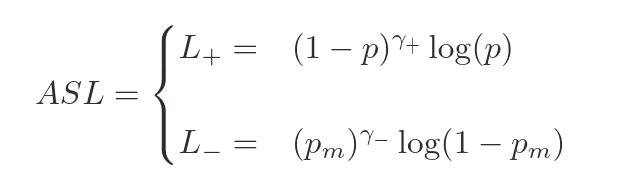

- explanation: We propose to decouple the focusing levels of the positive and negative samples. Let γ+ and γ− be the positive and negative focusing parameters, respectively. We obtain asymmetric focusing by redefining the loss: Since we are interested in emphasizing the contribution of positive samples, we usually set γ− > γ+. Asymmetric focusing decouples the decay rates of positive and negative samples. Through this, we achieve better control over the contribution of positive and negative samples to the loss function, and help the network learn meaningful features from positive samples, despite their rarity.

- masking: since we have uncertain `-1` labels, we mask off loss values at those positions. 

In [21]:
class MaskedAsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(MaskedAsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        mask = torch.ones_like(self.targets).to(self.targets)
        mask[torch.where(self.targets==-1)] = 0 # mask missing final labels
        
        self.loss *= mask
            
        return -self.loss.mean()

# Model
---

In [22]:
model = AutoModelForImageClassification.from_pretrained(
    'facebook/convnextv2-tiny-22k-384',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/115M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-22k-384 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Metrics

- the metrics used in the CheXpert paper is label-wise `AUROC`
- I also included additional metrics: 
    - label-wise `Specificity`: (true negative rate) is the probability of a negative test result, conditioned on the individual truly being negative.
    - `Exact Match`: all the labels for a sample must match exactly
    - Hamming Distance: the Hamming distance between two strings or vectors of equal length is the number of positions at which the corresponding symbols are different

In [23]:
def compute_metrics(eval_preds):
    target_cols = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
    logits, labels = eval_preds
    logits, labels = torch.from_numpy(logits), torch.from_numpy(labels).long()
    auroc = multilabel_auroc(logits, labels,num_labels=5,ignore_index=-1,average='none').numpy()
    exact_match = multilabel_exact_match(logits, labels, num_labels=5,ignore_index=-1).item()
    specificity = multilabel_specificity(logits, labels, num_labels=5,ignore_index=-1,average='none').numpy()
    hamming_dist = multilabel_hamming_distance(logits, labels, num_labels=5,ignore_index=-1).item()
    
    auroc_values = {f"auroc_{c}":a for c,a in zip(target_cols, auroc)}
    specificity_values = {f"specificity_{c}":a for c,a in zip(target_cols, specificity)}
    return {
        **auroc_values,
        **specificity_values,
        'exact_match': exact_match,
        'hamming_distance': hamming_dist
    }

# Trainer

In [24]:
class ChexpertTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop('labels')
        outputs = model(**inputs)
        loss = MaskedAsymmetricLossOptimized(gamma_neg=3)(outputs.logits, labels)
        
        return (loss, outputs) if return_outputs else loss

In [25]:
training_args = TrainingArguments(
    output_dir="./convnextv2-tiny-chexpert_checkpoints",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    do_eval=True,
    dataloader_drop_last=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=500,
    lr_scheduler_type='cosine',
    warmup_steps=1600,
    num_train_epochs=3,
    learning_rate=1e-3,
    weight_decay=0.02,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

In [26]:
trainer = ChexpertTrainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=valid_ds
)

In [27]:
trainer.train()

Epoch,Training Loss,Validation Loss,Auroc Atelectasis,Auroc Cardiomegaly,Auroc Consolidation,Auroc Edema,Auroc Pleural effusion,Specificity Atelectasis,Specificity Cardiomegaly,Specificity Consolidation,Specificity Edema,Specificity Pleural effusion,Exact Match,Hamming Distance
1,0.078900,0.077592,0.662846,0.844459,0.713472,0.846322,0.877124,0.943161,0.895083,0.999600,0.649620,0.709869,0.290360,0.187290
2,0.074300,0.073853,0.707278,0.860593,0.739481,0.858907,0.894519,0.771917,0.875769,0.993907,0.710050,0.619312,0.268656,0.202572
3,0.071900,0.071679,0.720720,0.867505,0.757017,0.871314,0.902476,0.770259,0.898223,0.973537,0.746389,0.696831,0.284045,0.188117


TrainOutput(global_step=18360, training_loss=0.07704388030473963, metrics={'train_runtime': 26391.0679, 'train_samples_per_second': 22.263, 'train_steps_per_second': 0.696, 'total_flos': 4.34610176750361e+19, 'train_loss': 0.07704388030473963, 'epoch': 3.0})

In [28]:
trainer.evaluate(test_ds)

{'eval_loss': 0.10279931873083115,
 'eval_auroc_Atelectasis': 0.7969785332679749,
 'eval_auroc_Cardiomegaly': 0.8262370228767395,
 'eval_auroc_Consolidation': 0.9332064390182495,
 'eval_auroc_Edema': 0.9075091481208801,
 'eval_auroc_Pleural Effusion': 0.9322017431259155,
 'eval_specificity_Atelectasis': 0.8231292366981506,
 'eval_specificity_Cardiomegaly': 0.9810126423835754,
 'eval_specificity_Consolidation': 1.0,
 'eval_specificity_Edema': 0.8351648449897766,
 'eval_specificity_Pleural Effusion': 0.8544303774833679,
 'eval_exact_match': 0.4419642984867096,
 'eval_hamming_distance': 0.1830357015132904,
 'eval_runtime': 7.6624,
 'eval_samples_per_second': 30.539,
 'eval_steps_per_second': 1.044,
 'epoch': 3.0}

In [29]:
trainer.save_model("./convnextv2-tiny-chexpert")
trainer.save_state()

# upcoming:

- Pseudo-labeling for the dataset for uncertain labels using TTA (test-time augmentation)
- Training a new model from the final labels.

# Thank You for Checking Out My Work!

## Follow [**@shreydan**](https://kaggle.com/shreydan) if you haven't already!
## Stay Tuned for more notebooks on this dataset :)